# Import Libraries

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns 
import os
import matplotlib.pyplot as plt

np.random.seed(2)

from sklearn.model_selection import train_test_split

from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, MaxPool2D, Dropout, Dense, Flatten, BatchNormalization, LeakyReLU 
from keras.optimizers import RMSprop
from keras.utils.np_utils import to_categorical
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau

sns.set(style='white', context='notebook', palette='deep')

Using TensorFlow backend.


# Load data

In [3]:
train_data = pd.read_csv('train.csv')
test_data = pd.read_csv('test.csv')

In [4]:
train_data.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [5]:
train_data.shape[0]

42000

In [6]:
Y_train = train_data['label']
X_train = train_data.drop(labels=['label'], axis=1)

In [7]:
# Free some space
del train_data

1    4684
7    4401
3    4351
9    4188
2    4177
6    4137
0    4132
4    4072
8    4063
5    3795
Name: label, dtype: int64
AxesSubplot(0.125,0.125;0.775x0.755)


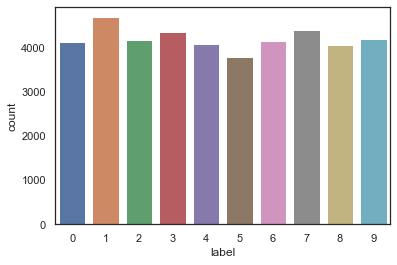

In [8]:
print(Y_train.value_counts())
print(sns.countplot(Y_train))

# Data cleaning

In [9]:
X_train.isnull().any().describe()

count       784
unique        1
top       False
freq        784
dtype: object

In [10]:
test_data.isnull().any().describe()

count       784
unique        1
top       False
freq        784
dtype: object

---
!!! NO MISSING VALUES !!!

# Normalize

In [11]:
X_train /= 255.
test_data /= 255.

# Reshape

In [12]:
img_rows, img_cols = 28, 28

X_train = X_train.values.reshape(-1, img_rows, img_cols, 1)
test_data = test_data.values.reshape(-1, img_rows, img_cols, 1)

In [13]:
Y_train = to_categorical(Y_train, 10)

# Split training and validation set

In [14]:
random_seed = 2

In [15]:
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=0.1, random_state=random_seed)

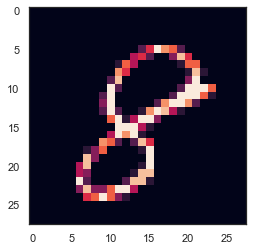

In [16]:
plt.imshow(X_train[0][:, :, 0])

# Define model

In [17]:
model = Sequential()

# model.add(Conv2D(32, (5, 5), activation='relu', padding='same', input_shape=(img_rows, img_cols, 1)))
# model.add(BatchNormalization())
# model.add(MaxPooling2D(pool_size=(2, 2)))
# model.add(Dropout(0.25))

# model.add(Conv2D(64, (1, 1), activation='relu', padding='same'))
# model.add(BatchNormalization())
# model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
# model.add(Dropout(0.25))

# model.add(Flatten())

# model.add(Dense(512, activation='relu'))
# model.add(BatchNormalization())
# model.add(Dropout(0.5))

# model.add(Dense(10, activation='softmax'))

model.add(Conv2D(filters = 32, kernel_size = (5,5), kernel_initializer='he_normal', input_shape=(28,28,1)))
model.add(LeakyReLU(alpha = 0.2))
model.add(Conv2D(filters = 32, kernel_size = (5,5), kernel_initializer='he_normal'))
model.add(LeakyReLU(alpha = 0.2))
model.add(MaxPool2D(pool_size=(2,2), strides=(2, 2)))
model.add(Dropout(0.25))


model.add(Conv2D(filters = 64, kernel_size = (3,3), kernel_initializer='he_normal'))
model.add(LeakyReLU(alpha = 0.2))
model.add(Conv2D(filters = 64, kernel_size = (3,3), kernel_initializer='he_normal'))
model.add(LeakyReLU(alpha = 0.2))
model.add(MaxPool2D(pool_size=(1, 1), strides=(2,2)))
model.add(Dropout(0.25))


model.add(Flatten())
model.add(BatchNormalization())
model.add(Dense(512))
model.add(LeakyReLU(alpha = 0.2))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(10, activation = "softmax"))

model.summary()

Instructions for updating:
If using Keras pass *_constraint arguments to layers.

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 24, 24, 32)        832       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 24, 24, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 20, 20, 32)        25632     
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 20, 20, 32)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 10, 10, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 10, 10, 32)        0         
______________________________________

# Compile

In [18]:
model.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

In [19]:
learning_rate_reduction = ReduceLROnPlateau(
    monitor='val_accuracy',
    patience=3,
    verbose=1,
    factor=0.5,
    min_lr=1e-5
)

In [20]:
epochs = 25
batch_size = 86

In [21]:
datagen = ImageDataGenerator(
    rotation_range=10,
    zoom_range=0.1,
    width_shift_range=0.1,
    height_shift_range=0.1,
)

datagen.fit(X_train)

## Fit the model

In [22]:
history = model.fit_generator(
    datagen.flow(X_train, Y_train, batch_size=batch_size),
    epochs=epochs,
    validation_data=(X_val, Y_val),
    verbose=2,
    steps_per_epoch=X_train.shape[0] // batch_size,
    callbacks=[learning_rate_reduction]
)


Epoch 1/25
 - 118s - loss: 0.6078 - accuracy: 0.8217 - val_loss: 0.0799 - val_accuracy: 0.9740
Epoch 2/25
 - 123s - loss: 0.2080 - accuracy: 0.9371 - val_loss: 0.0832 - val_accuracy: 0.9762
Epoch 3/25
 - 113s - loss: 0.1519 - accuracy: 0.9543 - val_loss: 0.0502 - val_accuracy: 0.9867
Epoch 4/25
 - 106s - loss: 0.1284 - accuracy: 0.9605 - val_loss: 0.0510 - val_accuracy: 0.9876
Epoch 5/25
 - 92s - loss: 0.1109 - accuracy: 0.9657 - val_loss: 0.0639 - val_accuracy: 0.9821
Epoch 6/25
 - 91s - loss: 0.1020 - accuracy: 0.9687 - val_loss: 0.0447 - val_accuracy: 0.9879
Epoch 7/25
 - 90s - loss: 0.0945 - accuracy: 0.9704 - val_loss: 0.0455 - val_accuracy: 0.9876
Epoch 8/25
 - 93s - loss: 0.0869 - accuracy: 0.9725 - val_loss: 0.0394 - val_accuracy: 0.9886
Epoch 9/25
 - 97s - loss: 0.0856 - accuracy: 0.9738 - val_loss: 0.0319 - val_accuracy: 0.9907
Epoch 10/25
 - 98s - loss: 0.0781 - accuracy: 0.9765 - val_loss: 0.0436 - val_accuracy: 0.9867
Epoch 11/25
 - 97s - loss: 0.0818 - accuracy: 0.9748 -

In [23]:
# h = model.fit(X_train, Y_train,
#           epochs=25, batch_size = None, steps_per_epoch = 37000//32,
#           validation_data = (X_val, Y_val),validation_steps = 5000//32)

In [24]:
model.save_weights('model.h5')

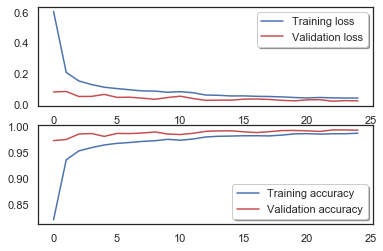

In [25]:
fig, ax = plt.subplots(2, 1)
ax[0].plot(history.history['loss'], color='b', label='Training loss')
ax[0].plot(history.history['val_loss'], color='r', label='Validation loss')
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(history.history['accuracy'], color='b', label='Training accuracy')
ax[1].plot(history.history['val_accuracy'], color='r', label='Validation accuracy', axes=ax[1])
legend = ax[1].legend(shadow=True)


# Predict

In [26]:
results = model.predict(test_data)

In [27]:
results = np.argmax(results, axis=1)

In [28]:
results = pd.Series(results, name='Label')

submission = pd.concat([pd.Series(range(1,28001),name = "ImageId"),results],axis = 1)

submission.to_csv("submission.csv",index=False)

In [29]:
test = pd.read_csv('submission.csv')

In [30]:
test.head()

,ImageId,Label
0,1,2
1,2,0
2,3,9
3,4,0
4,5,3
